In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy
from datetime import datetime
from scipy.special import logsumexp

In [2]:
from ca_utils import number_to_base, base_to_number

In [3]:
rng = np.random.RandomState(seed=int((datetime.now()-datetime(1970,1,1)).total_seconds()))

# Theory

We want use $P(s_{i}^{t})$ to indicate the probability of cell $i$ being in state $s\in S$ at step t of the cellular automata.

From this we can build row by row to get 

$$P\left(s_{i}^{t+1}\right)=\sum_{f=s_{i}^{t+1}}P\left(s_{i-1}^{t},s_{i}^{t},s_{i+1}^{t}\right)$$

where summation is performed over

$$f\left(s_{i-1}^{t},s_{i}^{t},s_{i+1}^{t}\right)=s_{i}^{t+1}$$

where $f(\dots)$ is the cellular automata update function.

To do this for an arbitary number of steps we need the joint probability of two neighbouring cells at each site and it's neighbour to the right i.e.

$$P\left(s_{i}^{t}, s_{i+1}^{t}\right)$$

extending the above gives

$$P\left(s_{i}^{t+1}, s_{i+1}^{t+1}\right)=\sum_{f=s_{i}^{t+1}, f=s_{i+1}^{t+1}}P\left(s_{i-1}^{t},s_{i}^{t},s_{i+1}^{t},s_{i+2}^{t}\right)$$

then using the chain rule of probabilities

$$\begin{align}
P\left(s_{i}^{t+1}, s_{i+1}^{t+1}\right) &=\sum_{f} P\left(s_{i}^{t},s_{i+1}^{t}\right)P\left(s_{i-1}^{t}|s_{i}^{t}\right)P\left(s_{i+2}^{t}|s_{i+1}^{t}\right)\\
&=\sum_{f} P\left(s_{i-1}^{t},s_{i}^{t}\right)P\left(s_{i+1}^{t},s_{i+2}^{t}\right)h\left(s_{i}^{t},s_{i+1}^{t}\right)
\end{align}$$

where

$$h\left(s_{i}^{t},s_{i+1}^{t}\right)=\frac{P\left(s_{i}^{t},s_{i+1}^{t}\right)}{P\left(s_{i}^{t}\right)P\left(s_{i+1}^{t}\right)}$$

In addition we take the initial probabilities to be independent so that

$$P\left(s_{i}^{0},s_{i+1}^{0}\right)=P\left(s_{i}^{0}\right)P\left(s_{i+1}^{0}\right)$$

In practice we do this by:

- Generating an array of mappings from the quadruple of cells to the following tuples (i.e. $\left(s_{i-1}^{t},s_{i}^{t},s_{i+1}^{t},s_{i+2}^{t}\right)\rightarrow\left(s_{i}^{t+1},s_{i+1}^{t+1}\right)$ based on the update rule
- Create an empty array for joint probabilities in the shape $|S|\times|S|\times width\times steps$
- Set the initial joint probability row from the initial state, using the independence of the initial states

# Generate Rule Matrix

In [4]:
def gen_rule(n, ids=None, perbs=None):
    """Generate array represting a ca-rule with possible pertubations"""
    
    ids = ids or ()
    perbs = perbs or ()
    
    r = number_to_base(n, base=2, width=8).astype('float')
    
    for j, k in zip(ids, perbs):
        r[j] = r[j] - k if r[j]>0 else r[j]+k
    
    rp = np.zeros((8, 2)) 
    rp[:, 1] = r
    rp[:, 0] = 1 - rp[:, 1]
    
    return rp

## Convert Rule Array to Rule Look-UP

In [5]:
def get_rule(r_array, n_states):
    
    ret = np.zeros((n_states, n_states, n_states**4, 5))
    
    for i in range(0, n_states**2):
        
        k = number_to_base(i, base=n_states, width=2)
    
        for j in range(n_states**4):
            
            nb = number_to_base(j, base=n_states, width=4)
            a = base_to_number(nb[:3], base=n_states)
            b = base_to_number(nb[1:], base=n_states)
            ret[k[0],k[1], j, :4] = nb
            ret[k[0],k[1], j, 4] = r_array[a][k[0]]*r_array[b][k[1]]
    
    return ret

### Example:

In [6]:
foo = gen_rule(110)
bar= get_rule(foo, 2)

In [7]:
bar[0][0]

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 1., 1., 0., 0.],
       [1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1.],
       [1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       [1., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0.],
       [1., 0., 1., 1., 0.],
       [0., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]])

## Model Runner

In [8]:
def runner(rule_arr, steps, width, n_states=2, region_width=0, p_error=0):
    
    # Create rule mapping
    rule_map = get_rule(rule_arr, n_states)
    
    # Initial State
    s0 = rng.randint(0, n_states, size=width)
    
    # Vector p(i)
    p0 = np.zeros((width, n_states), dtype='float64')
    
    # Initialzie probs from initial binary state
    for i, j in enumerate(s0):
        p0[i, j] = 1-p0[i, j]
    
    # Add noise to a central region
    if region_width>0:
        d = region_width//2
        mid = width//2 - d
        rands = 0.001*rng.random(size=region_width)
        for i in range(region_width):
            if p0[mid+i, 0] > 0:
                p0[mid+i, 0] = p0[mid+i, 0] - rands[i]
                p0[mid+i, 1] = p0[mid+i, 1] + rands[i]
            else:
                p0[mid+i, 1] = p0[mid+i, 1] - rands[i]
                p0[mid+i, 0] = p0[mid+i, 0] + rands[i]
    
    # Shift probabilities array to the right
    shift_p0 = p0.take(np.arange(1, width+1), mode='wrap', axis=0)
    
    # Initialize empty joint probability array with steps and width
    joint = np.zeros((steps, width, n_states, n_states), dtype='float64')
    
    # And then get the joint (indipendent) probability
    joint[0, :, 0, 0] = p0[:, 0]*shift_p0[:, 0]
    joint[0, :, 1, 0] = p0[:, 1]*shift_p0[:, 0]
    joint[0, :, 0, 1] = p0[:, 0]*shift_p0[:, 1]
    joint[0, :, 1, 1] = p0[:, 1]*shift_p0[:, 1]
    
    # Update function called each step
    def update(x, y, l_arr, c_arr, r_arr, p_arr0, p_arr1):
        r_map = rule_map[x][y][:, :4].astype('int')
        r_prob = rule_map[x][y][:, 4:]
        den = [p_arr0[:, r[1]]*p_arr1[:, r[2]] for r in r_map]
        num = [l_arr[:, r[0],r[1]]*c_arr[:, r[1],r[2]]*r_arr[:, r[2],r[3]] for r in r_map]
        slices = [np.divide(n, d, out=np.zeros_like(n), where=d!=0) for n, d in zip(num, den)]
        slices = np.multiply(r_prob, slices)
        return np.stack(slices).sum(axis=0)
    
    # Update each row in turn from previous row
    for i in range(1, joint.shape[0]):
        
        joint_t = joint[i-1]
        
        # Left and right shifts
        shift_lt = joint_t.take(np.arange(-1, width-1), mode='wrap', axis=0)
        shift_rt = joint_t.take(np.arange( 1, width+1), mode='wrap', axis=0)
        
        # Per-site marginal probabilities
        probs = joint_t.sum(axis=2)
        
        # Shifted marginals
        probs_r = probs.take(np.arange(1, width+1), mode='wrap', axis=0)
        
        # Update each of the joint probabilities
        joint[i, :, 0, 0] = update(0, 0, shift_lt, joint_t, shift_rt, probs, probs_r)
        joint[i, :, 1, 0] = update(1, 0, shift_lt, joint_t, shift_rt, probs, probs_r)
        joint[i, :, 0, 1] = update(0, 1, shift_lt, joint_t, shift_rt, probs, probs_r)
        joint[i, :, 1, 1] = update(1, 1, shift_lt, joint_t, shift_rt, probs, probs_r)
        
    return joint

## Mutual Information

In [9]:
def mutual_info(arr):
    p0 = np.sum(arr, axis=3)
    p1 = np.sum(arr, axis=2)
    
    def sub_mut(i, j):
        return np.multiply(arr[:,:,i,j], np.log(arr[:,:,i,j])- np.log(p0[:,:,i]*p1[:,:,j]), 
                           out=np.zeros_like(arr[:,:,i,j]), where=arr[:,:,i,j]!=0) 
    
    m00 = sub_mut(0, 0)
    m10 = sub_mut(1, 0)
    m01 = sub_mut(0, 1)
    m11 = sub_mut(1, 1)
    
    return m00 + m10 + m01 + m11

## Sanity Checks

In [10]:
rp = gen_rule(110, [], [])

In [11]:
foo = runner(rp, 500, 500, p_error=0.001)

In [12]:
np.isclose(foo[10].sum(axis=1), foo[10].sum(axis=2).take(np.arange(1,foo[10].shape[0]+1), mode='wrap', axis=0)).all()

True

In [13]:
np.isclose(1, np.sum(foo)/(500*500))

True

## Plotter for Mutual Info

In [14]:
def mutual_info_plot_runner(rule_arrs, steps, width, w=3, region_width=10, p_error=0):
    n_plots = len(rule_arrs)
    h = (n_plots - n_plots%w)//w + min(1, n_plots%w)
    
    f, ax = plt.subplots(h, w, figsize=(18, 6*h))
    f.tight_layout()
            
    for i, r in enumerate(rule_arrs):
        x, y = i%w, (i - i%w)//w
        a = runner(r, steps, width, n_states=2, region_width=region_width, p_error=p_error)
        mut_info = mutual_info(a)
        ax[y][x].matshow(mut_info[:], cmap=plt.get_cmap('twilight'));
        ax[y][x].text(5, -10, f'Rule {r}')
        
    for i in ax:
        for j in i:
            j.set_xticks([])
            j.set_yticks([])

In [ ]:
mutual_info_plot_runner([rp for _ in range(4)], 500, 500, p_error=0.0)

## Plotter for Entropy Plots

In [15]:
def entropy_plot_runner(rules, steps, width, w=3):
    n_plots = len(rules)
    h = (n_plots - n_plots%w)//w + min(1, n_plots%w)
    
    f, ax = plt.subplots(h, w, figsize=(18, 6*h))
    f.tight_layout()
            
    for i, r in enumerate(rules):
        x, y = i%w, (i - i%w)//w
        rar = gen_rule(r, list(range(8)), [0.0001 for _ in range(8)])
        a = runner(rar, steps, width, n_states=2)
        ent = mutual_info(a) #entropy(a.reshape(a.shape[0], a.shape[1], -1), axis=2)
        ax[y][x].matshow(ent[200:], cmap=plt.get_cmap('bone'));
        ax[y][x].text(5, -10, f'Rule {r}')
        
    for i in ax:
        for j in i:
            j.set_xticks([])
            j.set_yticks([])

/home/jordan/anaconda3/envs/probabilistic_ca/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/jordan/anaconda3/envs/probabilistic_ca/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


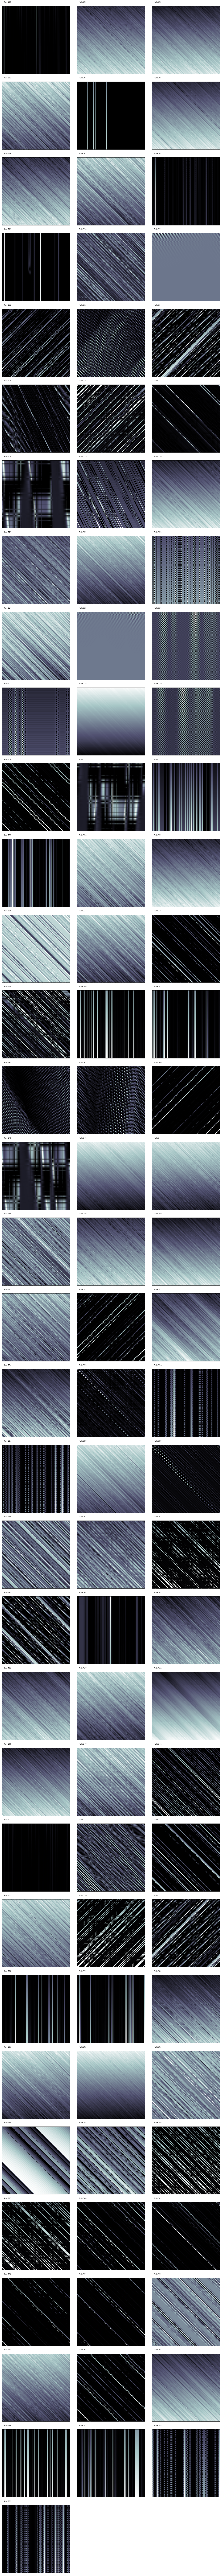

In [16]:
entropy_plot_runner(range(100, 200), 400, 200)

## Off-Diagonal Plot Runner

In [ ]:
def off_diag_plot_runner(rules, steps, width, w=3):
    n_plots = len(rules)
    h = (n_plots - n_plots%w)//w + min(1, n_plots%w)
    
    f, ax = plt.subplots(h, w, figsize=(18, 6*h))
    f.tight_layout()
            
    for i, r in enumerate(rules):
        x, y = i%w, (i - i%w)//w
        rar = gen_rule(r, list(range(8)), [0.0001 for _ in range(8)])
        a = runner(rar, steps, width, n_states=2)
        ent = a[:, :, 0, 1]+a[:, :, 1, 1]
        ax[y][x].matshow(ent, cmap=plt.get_cmap('bone'));
        ax[y][x].text(5, 10, f'Rule {r}')
        
    for i in ax:
        for j in i:
            j.set_xticks([])
            j.set_yticks([])

In [ ]:
off_diag_plot_runner(range(100, 150), 500, 500)

## Twin Plot Runner

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize, minmax_scale

In [ ]:
def joint_plot_runner(rules, steps, width, w=3, region_width=0, p_error=0):
    n_plots = len(rules)
    
    f, ax = plt.subplots(3*n_plots, 1, figsize=(18, 14*n_plots))
    f.tight_layout()
            
    for i, r in enumerate(rules):
        a = runner(r, steps, width, n_states=2, region_width=region_width, p_error=p_error)
        mut = mutual_info(a)
        mut = minmax_scale(mut, axis=1)
        ent = entropy(a.reshape(a.shape[0], a.shape[1], -1), axis=2)
        ent = minmax_scale(ent, axis=1)
        act = np.sum(a, axis=3)[:,:,1]
        ax[3*i].matshow(mut, cmap=plt.get_cmap('plasma'));
        ax[3*i+1].matshow(ent, cmap=plt.get_cmap('plasma'));
        ax[3*i+2].matshow(act, cmap=plt.get_cmap('binary'));
        
    for i in ax:
        i.set_xticks([])
        i.set_yticks([])

In [ ]:
rp = gen_rule(18, np.arange(8), [0.000001 for _ in range(8)])

In [ ]:
%%capture --no-display
joint_plot_runner([rp for _ in range(4)], 200, 600)